- 数据预处理  - 使用ImageDataGenerator方法
- 卷积网络模型 - conv2D
- 过拟合问题 -数据增强 ： 图像数据增强方法和效果
- 迁移学习 - 使用类似模型的参数进行训练

In [13]:
import os

# 数据所在文件夹
base_dir = './data/cat_and_dog'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')

# 验证集
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### `Conv2D` 参数总结表格  

| 参数名 | 说明 | 常见取值 |
|--------|------|---------|
| `filters` | 过滤器（卷积核）数量，决定输出通道数 | `32`, `64`, `128` |
| `kernel_size` | 卷积核大小，影响感受野 | `(3,3)`, `(5,5)` |
| `strides` | 步长，控制卷积核滑动步幅 | `(1,1)`, `(2,2)` |
| `padding` | 填充方式，决定输出大小 | `'valid'`（无填充）, `'same'`（保持尺寸） |
| `activation` | 激活函数，增加非线性 | `'relu'`, `'sigmoid'`, `'tanh'` |
| `input_shape` | 仅第一层需要指定输入尺寸 | `(height, width, channels)` |
| `use_bias` | 是否使用偏置项 | `True`, `False` |
| `kernel_initializer` | 权重初始化方法 | `'glorot_uniform'`, `'he_normal'` |
| `kernel_regularizer` | 正则化，防止过拟合 | `l1(0.01)`, `l2(0.01)` |


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3) ,activation='relu' , input_shape= (64,64,3)),
    # （输入大小 - 卷积核大小） / 步长  +  1
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3) ,activation='relu' ),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3) ,activation='relu' ),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation = 'relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

d:\Anaconda\envs\python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,569 (9.36 MB)

 Trainable params: 2,453,569 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = 'binary_crossentropy',
    metrics=['acc']
)

###  ImageDataGenerator
以下是 `flow_from_directory` 的功能及用法的详细说明：

**功能**
`flow_from_directory` 是 Keras 中 `ImageDataGenerator` 类的方法，**用于从按类别分组的目录结构中批量加载图像数据**。主要功能包括：
1. **自动分配标签**：根据子目录名称（如 `cats`、`dogs`）自动为图像生成标签。
2. **支持数据增强**：可结合 `ImageDataGenerator` 的预处理功能（如旋转、缩放、翻转等）实时增强数据。
3. **内存高效**：逐批次加载图像，避免一次性加载全部数据到内存中。
4. **兼容模型训练**：直接生成与 Keras 模型兼容的 `(x, y)` 数据流。



 **核心参数**
| 参数 | 作用 | 常用值示例 |
|------|------|------------|
| `directory` | 数据根目录路径（需包含子文件夹） | `./data/train` |
| `target_size` | 调整图像尺寸 | `(150, 150)` |
| `batch_size` | 每批次的样本数 | `32` |
| `class_mode` | 标签类型 | `"binary"`（二分类）、`"categorical"`（多分类） |
| `color_mode` | 图像颜色模式 | `"rgb"`（彩色）、`"grayscale"`（灰度） |
| `shuffle` | 是否打乱数据顺序 | `True`（训练集）、`False`（验证集） |
| `seed` | 随机种子（保证可重复性） | `42` |
| `subset` | 数据子集（需结合 `validation_split`） | `"training"`、`"validation"` |

 **使用示例**
```python
  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  # 创建数据生成器（可选数据增强）
  train_datagen = ImageDataGenerator(
      rescale=1./255,          # 归一化像素值
      rotation_range=20,       # 随机旋转角度
      horizontal_flip=True     # 随机水平翻转
  )

  # 从目录加载训练数据
  train_generator = train_datagen.flow_from_directory(
      directory="./data/train",      # 训练集根目录
      target_size=(150, 150),       # 调整图像尺寸
      batch_size=32,
      class_mode="binary",           # 二分类任务（标签为 0/1）
      shuffle=True,                 # 打乱顺序
      seed=42
  )

  # 验证集生成器（通常无需增强）
  val_datagen = ImageDataGenerator(rescale=1./255)
  val_generator = val_datagen.flow_from_directory(
      directory="./data/validation",
      target_size=(150, 150),
      batch_size=32,
      class_mode="binary",
      shuffle=False  # 验证集通常不洗牌
  )
```


 **输出示例**
运行后会输出数据统计信息：
```
Found 2000 images belonging to 2 classes.  # 训练集
Found 800 images belonging to 2 classes.   # 验证集
```



 **关键注意事项**
1. **目录结构要求**  
   目录必须按类别分文件夹存放，例如：
```
   data/
     train/
       cats/       # 类别1
         cat1.jpg
         cat2.jpg
       dogs/       # 类别2
         dog1.jpg
         dog2.jpg
     validation/   # 验证集结构同上
```

2. **标签分配规则**  
   标签按子文件夹的字母顺序分配。例如：  
   - `cats` → 标签 `0`  
   - `dogs` → 标签 `1`  
   可通过 `class_indices` 属性查看映射关系：  
   ```python
   print(train_generator.class_indices)  # 输出: {'cats': 0, 'dogs': 1}
   ```

3. **数据增强配置**  
   - 训练集通常需要增强（如旋转、翻转），验证集只需归一化。
   - 使用 `save_to_dir` 参数可保存增强后的图像（用于调试）。


 **优势**
- **自动化管理**：无需手动编写标签文件。
- **灵活性**：支持动态数据增强和实时预处理。
- **内存友好**：适合处理大规模图像数据集。

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# rescale = 1. /255 图像归一化
train_datagen = ImageDataGenerator(rescale = 1. /255)
test_datagen = ImageDataGenerator(rescale = 1. /255)

In [14]:

train_generator = train_datagen.flow_from_directory(
    train_dir, # 文件路径
    target_size =(64,64),
    batch_size =20,
    class_mode = 'binary',
)

val_generator = test_datagen.flow_from_directory(
    validation_dir, # 文件路径
    target_size =(64,64),
    batch_size =20,
    class_mode = 'binary',
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**1. `fit()` 适用于小数据集**
- 适合**可以完全载入内存**的数据集，比如 `numpy` 数组格式的数据。
- 直接传入 `X_train` 和 `y_train` 训练数据。

**示例：**
```python
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
```
 **缺点**：当数据集太大，无法一次性加载到内存时，会导致**内存溢出**。


**2. `fit_generator()` 适用于大数据集**
- 通过 `ImageDataGenerator` 或其他 `Python Generator` **逐批**加载数据，避免一次性占用大量内存。
- 适合处理**大量图像、视频或文本数据**。

**示例：**
```python
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

model.fit_generator(train_generator, epochs=10, steps_per_epoch=100)
```
 **注意**：  
- `steps_per_epoch=100` 表示每个 epoch 训练 **100 批次**，每批次 `32` 张图片（`batch_size=32`）。
- **Keras 2.1.0 之后**，`fit_generator()` 的功能**已整合到 `fit()`**，现在可以直接使用 `fit()` 代替。

`fit_generator()` **已被弃用**，官方建议**使用 `fit()`** 直接传入 `generator`：
```python
model.fit(train_generator, epochs=10, steps_per_epoch=100)
```
它会**自动识别** `train_generator` 是生成器，并按需加载数据，等效于 `fit_generator()`。

---



In [15]:
import warnings
warnings.filterwarnings('ignore')
history = model.fit(train_generator , steps_per_epoch= 100 , epochs= 10, validation_data=val_generator,
                    validation_steps = 50 , verbose = 2)

Epoch 1/10
100/100 - 13s - 125ms/step - acc: 0.5325 - loss: 0.6895 - val_acc: 0.6190 - val_loss: 0.6740
Epoch 2/10
100/100 - 12s - 124ms/step - acc: 0.6200 - loss: 0.6557 - val_acc: 0.6000 - val_loss: 0.6527
Epoch 3/10
100/100 - 11s - 107ms/step - acc: 0.6880 - loss: 0.6094 - val_acc: 0.6150 - val_loss: 0.6449
Epoch 4/10
100/100 - 10s - 98ms/step - acc: 0.7000 - loss: 0.5793 - val_acc: 0.6150 - val_loss: 0.6509
Epoch 5/10
100/100 - 9s - 94ms/step - acc: 0.7335 - loss: 0.5367 - val_acc: 0.6950 - val_loss: 0.5725
Epoch 6/10
100/100 - 11s - 108ms/step - acc: 0.7560 - loss: 0.5103 - val_acc: 0.6920 - val_loss: 0.5614
Epoch 7/10
100/100 - 10s - 103ms/step - acc: 0.7695 - loss: 0.4827 - val_acc: 0.7130 - val_loss: 0.5560
Epoch 8/10
100/100 - 11s - 106ms/step - acc: 0.7760 - loss: 0.4580 - val_acc: 0.7200 - val_loss: 0.5464
Epoch 9/10
100/100 - 10s - 104ms/step - acc: 0.8045 - loss: 0.4447 - val_acc: 0.7200 - val_loss: 0.5478
Epoch 10/10
100/100 - 12s - 125ms/step - acc: 0.8245 - loss: 0.4079

### 结果展示


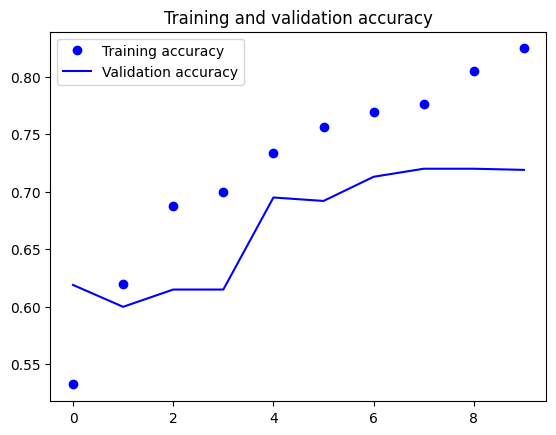

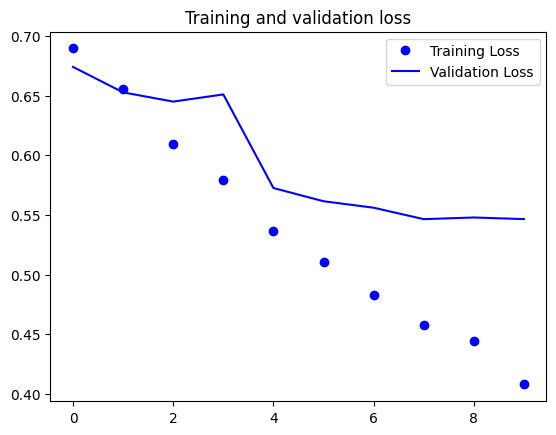

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 过拟合处理
- 增加样本数量
- 变换样本格式， 平移反转
- 正则化
- dorp-out

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. /255,
    rotation_range = 40,
    width_shift_range =0.2,
    height_shift_range =0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )